In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

df = pd.read_csv('claims_data.csv')

# Transform Target Variable (log-transform for skewed loss)
df['log_loss'] = np.log1p(df['loss'])
y = df['log_loss']
# Define numerical and categorical features
categorical_cols = [f'cat{i}' for i in range(1, 116)]
numerical_cols = [f'cont{i}' for i in range(1, 15)]
X = df[numerical_cols + categorical_cols]

In [9]:
# Preprocessing Pipeline (scale numerical, encode categorical)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [10]:
# Create Model Pipeline
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

In [11]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)
# Lasso Regression Before Tuning (Default alpha=1.0)
print("--- Results BEFORE Tuning (Default alpha=1.0) ---")
lasso_model.fit(X_train, y_train_log)
log_predictions_before = lasso_model.predict(X_test)
mae_log_before = mean_absolute_error(y_test_log, log_predictions_before)
r2_log_before = r2_score(y_test_log, log_predictions_before)
# Convert back to original scale for MAE
original_predictions_before = np.expm1(log_predictions_before)
y_test_original = np.expm1(y_test_log)
mae_before = mean_absolute_error(y_test_original, original_predictions_before)
print(f"R-squared (log scale): {r2_log_before:.4f}")
print(f"MAE (log scale): {mae_log_before:.4f}")
print(f"MAE (original scale): ${mae_before:,.2f}\n")


--- Results BEFORE Tuning (Default alpha=1.0) ---
R-squared (log scale): -0.0000
MAE (log scale): 0.6576
MAE (original scale): $1,797.81



In [12]:
# Hyperparameter Tuning using GridSearchCV
print("--- Running GridSearchCV to find best alpha... ---")
# Define a range of 'alpha' values to test
# We use 'regressor__alpha' because 'regressor' is the name of the Lasso step in your pipeline
param_grid = {
    'regressor__alpha': np.logspace(-2, 3, 20)  # 20 values from 0.01 to 1000
}

# GridSearchCV Setup
grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)
# run the tuning
grid_search.fit(X_train, y_train_log)
# get best parameter
best_alpha = grid_search.best_params_['regressor__alpha']
print(f"Best alpha found: {best_alpha:.4f}\n")

--- Running GridSearchCV to find best alpha... ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha found: 0.0100



In [13]:
# Using best alpha
print("--- Results AFTER Tuning (Best alpha) ---")
log_predictions_after = grid_search.predict(X_test)
# evaluate
mae_log_after = mean_absolute_error(y_test_log, log_predictions_after)
r2_log_after = r2_score(y_test_log, log_predictions_after)
# original scale
original_predictions_after = np.expm1(log_predictions_after)
mae_after = mean_absolute_error(y_test_original, original_predictions_after)
print(f"R-squared (log scale): {r2_log_after:.4f}")
print(f"MAE (log scale): {mae_log_after:.4f}")
print(f"MAE (original scale): ${mae_after:,.2f}\n")

--- Results AFTER Tuning (Best alpha) ---
R-squared (log scale): 0.4509
MAE (log scale): 0.4745
MAE (original scale): $1,311.73



--- 4. Generating Validation Plot... ---


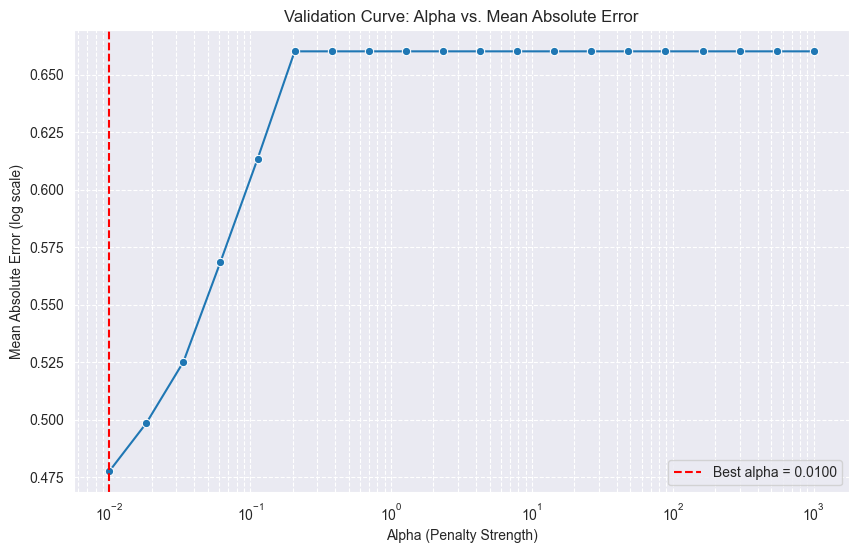

In [14]:
print("--- 4. Generating Validation Plot... ---")
# Get the results from the grid search
cv_results = grid_search.cv_results_
alphas = cv_results['param_regressor__alpha']
# We multiply by -1 because the score is 'neg_mean_absolute_error'
mean_test_scores = -cv_results['mean_test_score']
plt.figure(figsize=(10, 6))
sns.lineplot(x=alphas, y=mean_test_scores, marker='o')
plt.xscale('log')  # Use a log scale for alpha
plt.title('Validation Curve: Alpha vs. Mean Absolute Error')
plt.xlabel('Alpha (Penalty Strength)')
plt.ylabel('Mean Absolute Error (log scale)')
plt.grid(True, which="both", ls="--")
# Add a vertical line to show where the best alpha is
plt.axvline(x=best_alpha, color='red', linestyle='--', 
            label=f'Best alpha = {best_alpha:.4f}')
plt.legend()
plt.show()


Lasso selected 42 important features out of 816.


C:\Users\shemi\AppData\Local\Temp\ipykernel_24336\1258339379.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top_n), palette='viridis')


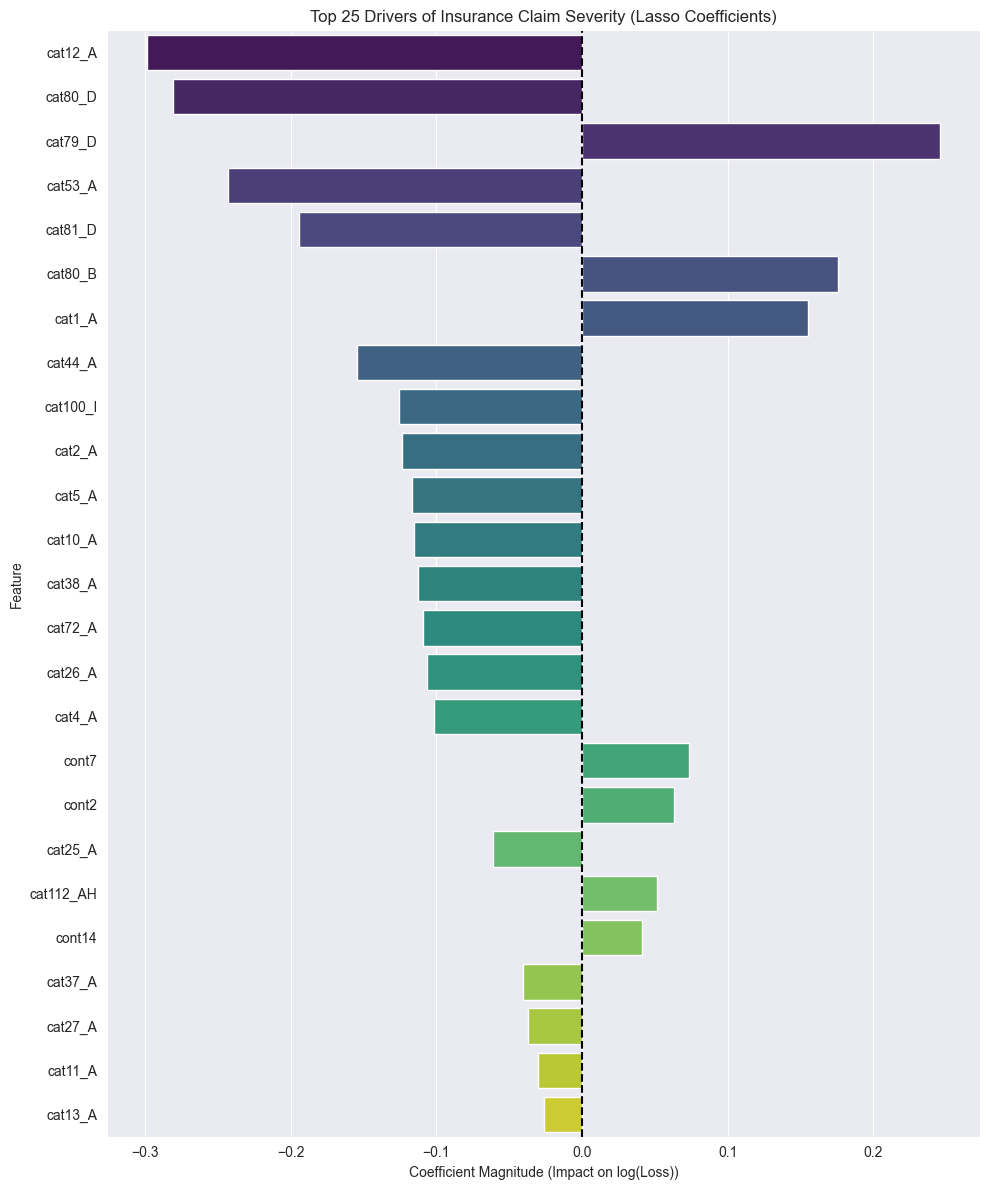


Top 5 Drivers of HIGHER Claim Costs:
     Feature  Coefficient  Abs_Coefficient
36   cat12_A    -0.298912         0.298912
185  cat80_D    -0.280838         0.280838
181  cat79_D     0.245890         0.245890
118  cat53_A    -0.243068         0.243068
189  cat81_D    -0.194161         0.194161

Top 5 Drivers of LOWER Claim Costs:
     Feature  Coefficient  Abs_Coefficient
36   cat12_A    -0.298912         0.298912
185  cat80_D    -0.280838         0.280838
118  cat53_A    -0.243068         0.243068
189  cat81_D    -0.194161         0.194161
100  cat44_A    -0.154541         0.154541


In [17]:
# Feature Selection Analysis (Lasso-specific: check sparsity)
num_zero_features = np.sum(grid_search.best_estimator_.named_steps['regressor'].coef_ == 0)
total_features = len(grid_search.best_estimator_.named_steps['regressor'].coef_)
print(f"Lasso selected {total_features - num_zero_features} important features out of {total_features}.")

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, cat_features])  # Note: Order matters
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': grid_search.best_estimator_.named_steps['regressor'].coef_})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
plt.figure(figsize=(10, 12))
top_n = 25
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top_n), palette='viridis')
plt.axvline(x=0, color='k', linestyle='--')
plt.title(f'Top {top_n} Drivers of Insurance Claim Severity (Lasso Coefficients)')
plt.xlabel('Coefficient Magnitude (Impact on log(Loss))')
plt.tight_layout()
plt.show()
print(f"\nTop 5 Drivers of HIGHER Claim Costs:")
print(coef_df.head(5))
print(f"\nTop 5 Drivers of LOWER Claim Costs:")
print(coef_df[coef_df['Coefficient'] < 0].head(5))

